In this notebook, I am trying to answer a question arising from the lecture of the following article: J. S. Furyk et al., “Emergency department presentations during the State of Origin rugby league series: a retrospective statewide analysis,” The Medical journal of Australia, vol. 197, no. 11, pp. 663–666, 2012.

The question is: they conclude they have a statistically significantly lower emergency room attendance during game days. Can we replicate their conclusion from their data?

# What is this about? 

This article is about determining whether there were fewer visits to emergency rooms during rugby event days. The data used in this article is as follows: 


> Main outcome measures: Number of patients presenting to Queensland EDs on 24 game days and 80 control days.

> In total, there were 49 702 ED presentations on game days and 172 351 presentations on control days.



Let's transform this data in a neat little table:

In [1]:
import pandas as pd
df = pd.DataFrame(data=[[24, 49702], [80, 172351]], 
                  index=['rugby game', 'control'], 
                  columns=['number of days', 'attendees'])
df

,number of days,attendees
rugby game,24,49702
control,80,172351


Now, let's do some simple math. What's the average number of people in the ER for these two categories of days?

In [2]:
df['attendees per day'] = df['attendees'] / df['number of days']
df

,number of days,attendees,attendees per day
rugby game,24,49702,2070.916667
control,80,172351,2154.387500


We see that on average, there were less people in the ER on game days than on control days. 83 to be precise:

In [31]:
df['attendees per day'].loc['control'] - df['attendees per day'].loc['rugby game']

83.470833333333303

Is 83 people more or less, compared to roughly 2100 a lot?

In [32]:
83 / 2100

0.039523809523809524

It's 4 percent. But did this value emerge by chance? Or is this statistically significant?

This is a tough question. We need a statiscal model to answer it.

Why? Because intuitively you know that there are many reasons to observe variations in numbers and doing it over 24 / 80 days averages the result, but maybe not enough. 

# Single day model 

Let's build our model for the number of patients for a single day. It is composed of:

- a mean attendance
- a standard deviation

We'll use a gaussian distribution based on these two values. Let's write a function that simulates a single day attendance:

In [5]:
import numpy as np
np.random.seed(42)

In [6]:
def single_day(mean, std):
    "Simulates the number of ER attendees for a single day."
    return np.random.normal(loc=mean, scale=std)

If we say that on average the standard deviation is a 100 people per day, we can simulate a distribution for a single day:

In [7]:
single_day(2100, 100)

2149.6714153011235

We can do this for 24 days in a row:

In [8]:
dist = [single_day(2100, 100) for _ in range(24)]
dist

[2086.1735698828816,
 2164.7688538100692,
 2252.3029856408025,
 2076.5846625276663,
 2076.5863043050817,
 2257.921281550739,
 2176.743472915291,
 2053.052561406505,
 2154.2560043585963,
 2053.6582307187537,
 2053.427024642974,
 2124.1962271566035,
 1908.67197553422,
 1927.5082167486967,
 2043.7712470759027,
 1998.7168879665576,
 2131.4247332595273,
 2009.1975924478788,
 1958.769629866471,
 2246.5648768921556,
 2077.4223699513464,
 2106.7528204687924,
 1957.5251813786542,
 2045.5617275474817]

Let's ask pandas about this distribution's mean and standard deviation:

In [9]:
pd.Series(dist).describe()

count      24.000000
mean     2080.898268
std        96.697184
min      1908.671976
25%      2035.127833
50%      2076.585483
75%      2137.132551
max      2257.921282
dtype: float64

One thing that appears in the above data is that the mean of the data does not necessarily reflect the mean we supplied to the generating function (2080 instead of 2100). The same goes for the standard deviation. This is a sample size effect which disappears if we work with large samples. We'll try 10x, 100x and 1000x larger samples below.

In [10]:
pd.Series([single_day(2100, 100) for _ in range(240)]).describe()

count     240.000000
mean     2100.234578
std        99.303645
min      1775.873266
25%      2029.066005
50%      2106.225511
75%      2162.773027
max      2485.273149
dtype: float64

In [11]:
pd.Series([single_day(2100, 100) for _ in range(2400)]).describe()

count    2400.000000
mean     2103.999784
std        98.471270
min      1798.048784
25%      2037.499539
50%      2102.853160
75%      2168.237130
max      2419.310757
dtype: float64

In [12]:
pd.Series([single_day(2100, 100) for _ in range(24000)]).describe()

count    24000.000000
mean      2099.943087
std         99.887928
min       1707.759975
25%       2032.403398
50%       2100.169540
75%       2167.442840
max       2547.908425
dtype: float64

We see a progression: 2080, 2100, 2103, 2099. This is a wiggly thing. That's the reason for which we need to do statistical tests to see if it's a significant thing to have a difference in 4% on average.

# Running statistical tests 

How do statistical tests work? I'll quote an illustration from Allen Downey found in his wonderful article: ["There is still only one test"](http://allendowney.blogspot.fr/2016/06/there-is-still-only-one-test.html).

![onlyonetest](https://lh4.googleusercontent.com/Bud31guq0w0FvylY57VMR0zHkYqxIpYAfOqgZietyvv1n2ToNEHwHKZWYix8pwct8kDKsZKiwvOWm6PIFEL3gBIQmbakQYHwVT02nn9_H8Fht_zaSBlrRNcqwZa950Vb5nt-5B84)

In [35]:
df['attendees'].sum() / (df['number of days'].sum())

2135.125

Our **data** is the number of ER people on game days (49 702) and on control days (172 351).

Our **model under the H0 hypothesis** ("there is no effect of rugby games") is that on average 2135.125 people visit the ER. Using our previously discussed random model, we can simulate a lot of samples of 24 / 80 days under this assumption.

**Test statistic**: using the data from the 80 control days and 24 game days, we'll simply substract the number of attendees in the control case from the number of attendees in the game case, normalizing by the number of days in control and game cases.

Let's use the [HypothesisTest class found in Allen Downey's book Think Stats2](http://greenteapress.com/thinkstats2/html/thinkstats2010.html) for this.

In [48]:
class HypothesisTest():
    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        return count / iters

    def TestStatistic(self, data):
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        raise UnimplementedMethodException()

Our only needed simulation parameter is going to be the standard deviation of the attendance or "by how many people can attendance vary per day". We'll use the arbitrarily value of 100 (for now).

In [72]:
std_param = 100 

We can generate our model easily with the function already defined previously:

In [73]:
class ERTest(HypothesisTest):
    "Model for replicating the Furyk et al. (2012) study."
    def __init__(self, data, std_param):
        super().__init__(data)
        self.std_param = std_param
        
    def TestStatistic(self, simulated_data):
        sum_game, sum_control = simulated_data
        test_stat = (sum_control / 80. - sum_game / 24.)
        return test_stat

    def RunModel(self):
        simulated_data = (sum(single_day(2135.125, self.std_param) for _ in range(24)),
                         sum(single_day(2135.125, self.std_param) for _ in range(80)))
        return simulated_data

Good, now we're ready to run our simulation.

In [74]:
data = (49702, 172351)

In [75]:
ert = ERTest(data, std_param)

In [76]:
ert.actual

83.4708333333333

In [77]:
ert.PValue(iters=10000)

0.0002

What this means is that using the above hypotheses, the likelihood to observe our actual result, with a difference in means of 83 people per day and the given sample sizes (24 / 80) is very unlikely to be due to chance. 


To get a better feeling for the distribution of the test statistic, let's plot it:

In [78]:
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [79]:
def plot_test_stat(test):
    "Plots the test statistic distribution and observed value."
    plt.hist(test.test_stats, bins=30, cumulative=False, normed=True)
    ylim = plt.ylim()
    plt.vlines(test.actual, *ylim, label='observed test stat')
    plt.legend(loc='upper left')
    plt.xlabel('people per day')

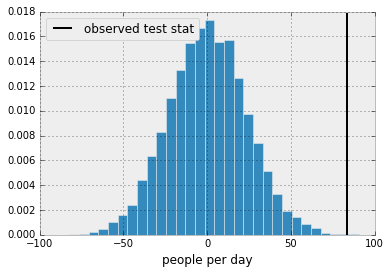

In [80]:
plot_test_stat(ert)

What this means is that if we had randomly taken 24 days and 80 days with a standard deviation of 100 people, there's almost no chance of observing a difference in number of people of 83.

What if the standard deviation was larger? Luckily we can repeat our experiment by changing only this value.

In [81]:
std_param = 500
ert1 = ERTest(data, std_param)
ert1.PValue(iters=10000)

0.2388

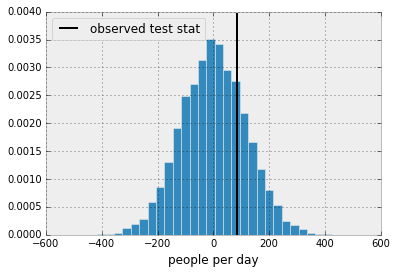

In [82]:
plot_test_stat(ert1)

Here, we see that the observed difference would be likely to be observed by chance. Having a difference of 83 people per day is likely to be normal over 24/80 days if numbers fluctuate by 500 people every day. 

The point of all of this is: if we don't know by how much numbers fluctuate every day and how (here I used a Gaussian assumption but really, I have no idea), we can't say if this is statistically significant. I wonder why the authors have not mentioned this basic statistic of their sample in the article.

# Conclusions and last plot 


To conclude, let's do a parametric plot of P-values, depending on the unknown parameter, the standard deviation of the number of people per day at the ER in Queensland, Australia.

In [96]:
pvalues = []
stds = [10, 50, 100, 150, 200, 250, 300, 350, 400, 500, 1000]
for std in stds:
    ert2 = ERTest(data, std)
    pvalues.append(ert2.PValue(iters=1000))

In [97]:
df2 = pd.DataFrame(data= [stds, pvalues], index=['std per day', 'p-value']).transpose()
df2

,std per day,p-value
0,10.0,0.000
1,50.0,0.000
2,100.0,0.001
3,150.0,0.007
4,200.0,0.035
5,250.0,0.083
6,300.0,0.113
7,350.0,0.155
8,400.0,0.198
9,500.0,0.230


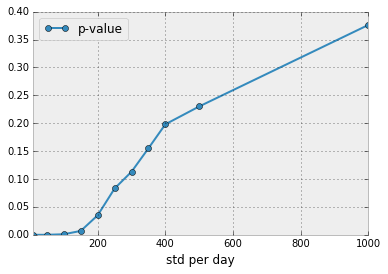

In [98]:
df2.plot.line(x='std per day', y='p-value', style='-o')

The point that this plot makes is: depending on the attendance at the ER, the numbers used in the study can or cannot be statistically significant. If the fluctuation in attendance for a 2100 people ER is above 200 people per day (roughly 10%), the numbers from the study would be judged non significant. On the other hand, if the numbers are around 50 people per day (low fluctuation) then there is a real effect. It would be interesting to contact the author about this point.